# Test Dual-Stream Time Series Forecasting Model

This notebook tests the iTransformer + Powerformer dual-stream architecture on weather data.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/Dual_encoding')
from model import Model

Mounted at /content/drive


In [2]:

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import glob
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader



print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

PyTorch version: 2.9.0+cu126
CUDA available: True
Using device: cuda


In [3]:
print("Current directory:", os.getcwd())

Current directory: /content/drive/MyDrive/Dual_encoding


## 1. Load and Explore Data

In [4]:
# Load and combine CSV files
csv_files = sorted(glob.glob('./data/mpi_saale_*.csv'))
dfs = [pd.read_csv(file) for file in csv_files]
df = pd.concat(dfs, ignore_index=True)

# Extract features (exclude 'Date Time' column)
data = df.iloc[:, 1:].copy()

# Replace missing data sentinels with NaN
data = data.replace('********', np.nan)
data = data.replace(-9999, np.nan)

# Convert all columns to numeric
for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Drop columns with >10% missing data
threshold = 10
missing_pct = (data.isnull().sum() / len(data)) * 100
high_missing_cols = missing_pct[missing_pct > threshold].index.tolist()
if high_missing_cols:
    data = data.drop(columns=high_missing_cols)

# Fill remaining missing values with forward fill
data_filled = data.ffill()

# Handle NaN at the beginning of series
for col in data_filled.columns:
    if data_filled[col].isnull().any():
        first_valid = data_filled[col].first_valid_index()
        if first_valid is not None and first_valid > 0:
            fill_value = data_filled[col].iloc[first_valid:first_valid+1000].median()
            data_filled[col].fillna(fill_value, inplace=True)
        else:
            data_filled[col].fillna(0, inplace=True)

# Drop any remaining rows with NaN
if data_filled.isnull().sum().sum() > 0:
    data_filled = data_filled.dropna()

# Convert to numpy array and normalize
data = data_filled.values
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)

# Verify clean data
assert not np.isnan(data_normalized).any(), "NaN values detected in normalized data"
assert not np.isinf(data_normalized).any(), "Inf values detected in normalized data"

/tmp/ipython-input-386905623.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_filled[col].fillna(fill_value, inplace=True)


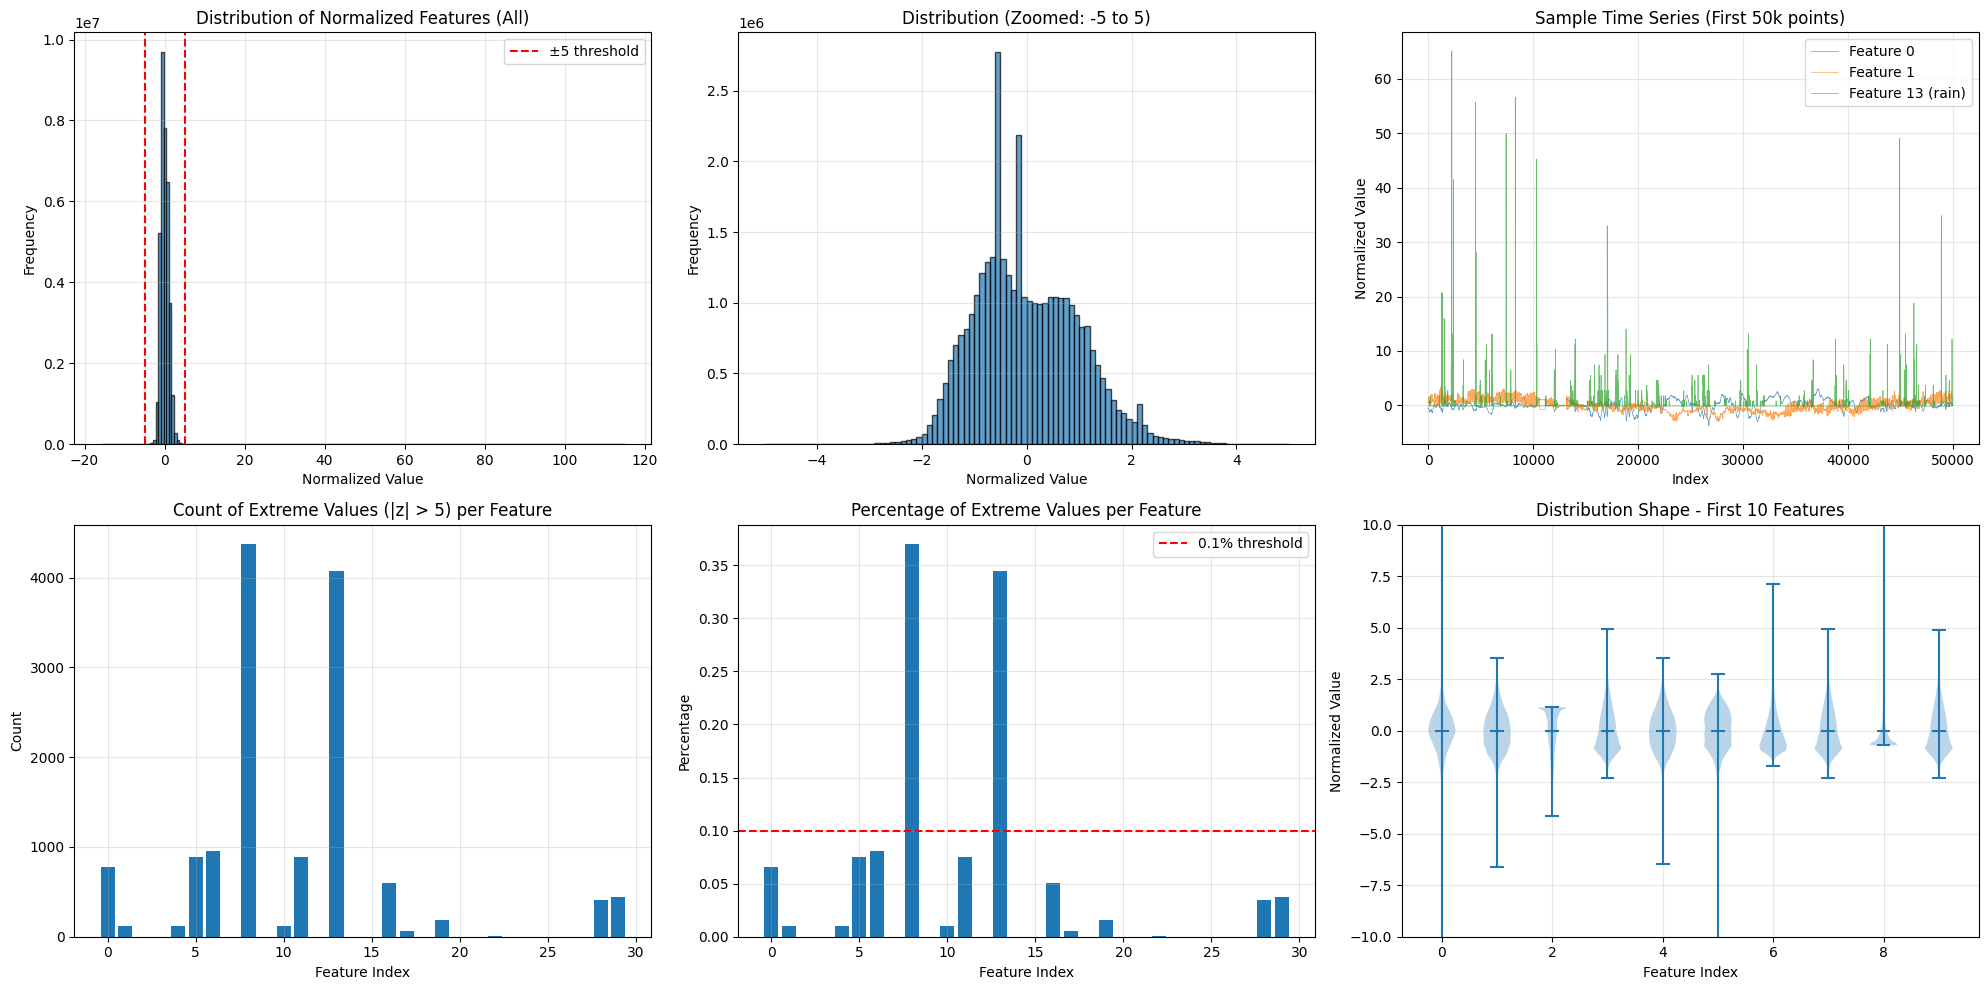


=== EXTREME VALUE ANALYSIS ===
Max normalized value: 115.17
Min normalized value: -15.97

Features with most extreme values (|z| > 5):
  VPdef (mbar): 4370 values (0.370%)
  rain (mm): 4076 values (0.345%)
  VPmax (mbar): 959 values (0.081%)
  wv (m/s): 885 values (0.075%)
  Tdew (degC): 884 values (0.075%)

Total extreme values: 14011 (0.040% of all data)


In [13]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(20, 10))

# 1. Distribution of normalized data
ax1 = plt.subplot(2, 3, 1)
plt.hist(data_normalized.flatten(), bins=200, edgecolor='black', alpha=0.7)
plt.title('Distribution of Normalized Features (All)')
plt.xlabel('Normalized Value')
plt.ylabel('Frequency')
plt.axvline(x=-5, color='r', linestyle='--', label='±5 threshold')
plt.axvline(x=5, color='r', linestyle='--')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Zoom in on main distribution
ax2 = plt.subplot(2, 3, 2)
plt.hist(data_normalized.flatten(), bins=100, range=(-5, 5), edgecolor='black', alpha=0.7)
plt.title('Distribution (Zoomed: -5 to 5)')
plt.xlabel('Normalized Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# 3. Time series of key features (sample)
ax3 = plt.subplot(2, 3, 3)
sample = 50000
plt.plot(data_normalized[:sample, 0], label='Feature 0', alpha=0.7, linewidth=0.5)
plt.plot(data_normalized[:sample, 1], label='Feature 1', alpha=0.7, linewidth=0.5)
plt.plot(data_normalized[:sample, 13], label='Feature 13 (rain)', alpha=0.7, linewidth=0.5)
plt.title('Sample Time Series (First 50k points)')
plt.xlabel('Index')
plt.ylabel('Normalized Value')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. Count extreme values per feature
ax4 = plt.subplot(2, 3, 4)
extreme_counts = []
for i in range(data_normalized.shape[1]):
    count = np.sum(np.abs(data_normalized[:, i]) > 5)
    extreme_counts.append(count)
plt.bar(range(len(extreme_counts)), extreme_counts)
plt.title('Count of Extreme Values (|z| > 5) per Feature')
plt.xlabel('Feature Index')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)

# 5. Percentage of extreme values
ax5 = plt.subplot(2, 3, 5)
extreme_pct = [(count / len(data_normalized)) * 100 for count in extreme_counts]
plt.bar(range(len(extreme_pct)), extreme_pct)
plt.title('Percentage of Extreme Values per Feature')
plt.xlabel('Feature Index')
plt.ylabel('Percentage')
plt.axhline(y=0.1, color='r', linestyle='--', label='0.1% threshold')
plt.legend()
plt.grid(True, alpha=0.3)

# 6. Feature-wise distributions
ax6 = plt.subplot(2, 3, 6)
plt.violinplot([data_normalized[:, i] for i in range(min(10, data_normalized.shape[1]))],
               positions=range(min(10, data_normalized.shape[1])),
               showmeans=True, showextrema=True)
plt.title('Distribution Shape - First 10 Features')
plt.xlabel('Feature Index')
plt.ylabel('Normalized Value')
plt.ylim(-10, 10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Detailed statistics
print("\n=== EXTREME VALUE ANALYSIS ===")
print(f"Max normalized value: {data_normalized.max():.2f}")
print(f"Min normalized value: {data_normalized.min():.2f}")
print(f"\nFeatures with most extreme values (|z| > 5):")
feature_names = df.columns[1:].tolist()
for i in np.argsort(extreme_counts)[-5:][::-1]:
    pct = (extreme_counts[i] / len(data_normalized)) * 100
    print(f"  {feature_names[i]}: {extreme_counts[i]} values ({pct:.3f}%)")

print(f"\nTotal extreme values: {sum(extreme_counts)} ({(sum(extreme_counts) / data_normalized.size) * 100:.3f}% of all data)")

## 2. Prepare Dataset

In [5]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, lookback=48, forecast=12):
        """
        Args:
            data: numpy array of shape [timesteps, num_variates]
            lookback: number of past timesteps to use
            forecast: number of future timesteps to predict
        """
        self.data = torch.FloatTensor(data)
        self.lookback = lookback
        self.forecast = forecast

    def __len__(self):
        return len(self.data) - self.lookback - self.forecast + 1

    def __getitem__(self, idx):
        # Input: [lookback, num_variates]
        x = self.data[idx:idx + self.lookback]
        # Target: [forecast, num_variates]
        y = self.data[idx + self.lookback:idx + self.lookback + self.forecast]
        return x, y

# Settings
lookback_steps = 96   # Use 96 timesteps (16 hours at 10-min intervals)
forecast_steps = 24   # Predict 24 timesteps (4 hours ahead)

print(f"Lookback window: {lookback_steps} steps")
print(f"Forecast window: {forecast_steps} steps")

Lookback window: 96 steps
Forecast window: 24 steps


In [6]:
# Train/test split (80/20)
train_size = int(0.8 * len(data_normalized))
train_data = data_normalized[:train_size]
test_data = data_normalized[train_size:]

print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

# Create datasets
train_dataset = TimeSeriesDataset(train_data, lookback_steps, forecast_steps)
test_dataset = TimeSeriesDataset(test_data, lookback_steps, forecast_steps)

print(f"\nTrain samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)

# Check one batch
x_sample, y_sample = next(iter(train_loader))
print(f"\nSample batch:")
print(f"  Input shape: {x_sample.shape}  (batch, lookback, variates)")
print(f"  Target shape: {y_sample.shape}  (batch, forecast, variates)")

Train data shape: (945753, 30)
Test data shape: (236439, 30)

Train samples: 945634
Test samples: 236320

Sample batch:
  Input shape: torch.Size([2048, 96, 30])  (batch, lookback, variates)
  Target shape: torch.Size([2048, 24, 30])  (batch, forecast, variates)


## 3. Initialize Model

In [7]:
# Model configuration
num_variates = data.shape[1]  # 30 weather variables

model = Model(
    num_variates=num_variates,
    lookback_steps=lookback_steps,
    forecast_steps=forecast_steps,

    d_model=128,  # Embedding dimension (same for both streams)

    # Stream 1: iTransformer
    n_heads_s1=8,
    n_layers_s1=4,
    d_ff_s1=256,
    dropout_s1=0.3,

    # Stream 2: Powerformer
    patch_len=2,
    stride=8,
    n_heads_s2=8,
    n_layers_s2=4,
    d_ff_s2=256,
    dropout_s2=0.3,
    attn_decay_scale=0.25,

    # Fusion
    n_heads_fusion=4,
)

model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model initialized!")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Model initialized!
Total parameters: 1,409,841
Trainable parameters: 1,409,841


## 4. Test Forward Pass

Input shape: torch.Size([2048, 96, 30])
Output shape: torch.Size([2048, 24, 30])
Initial MSE (untrained): 1.1071


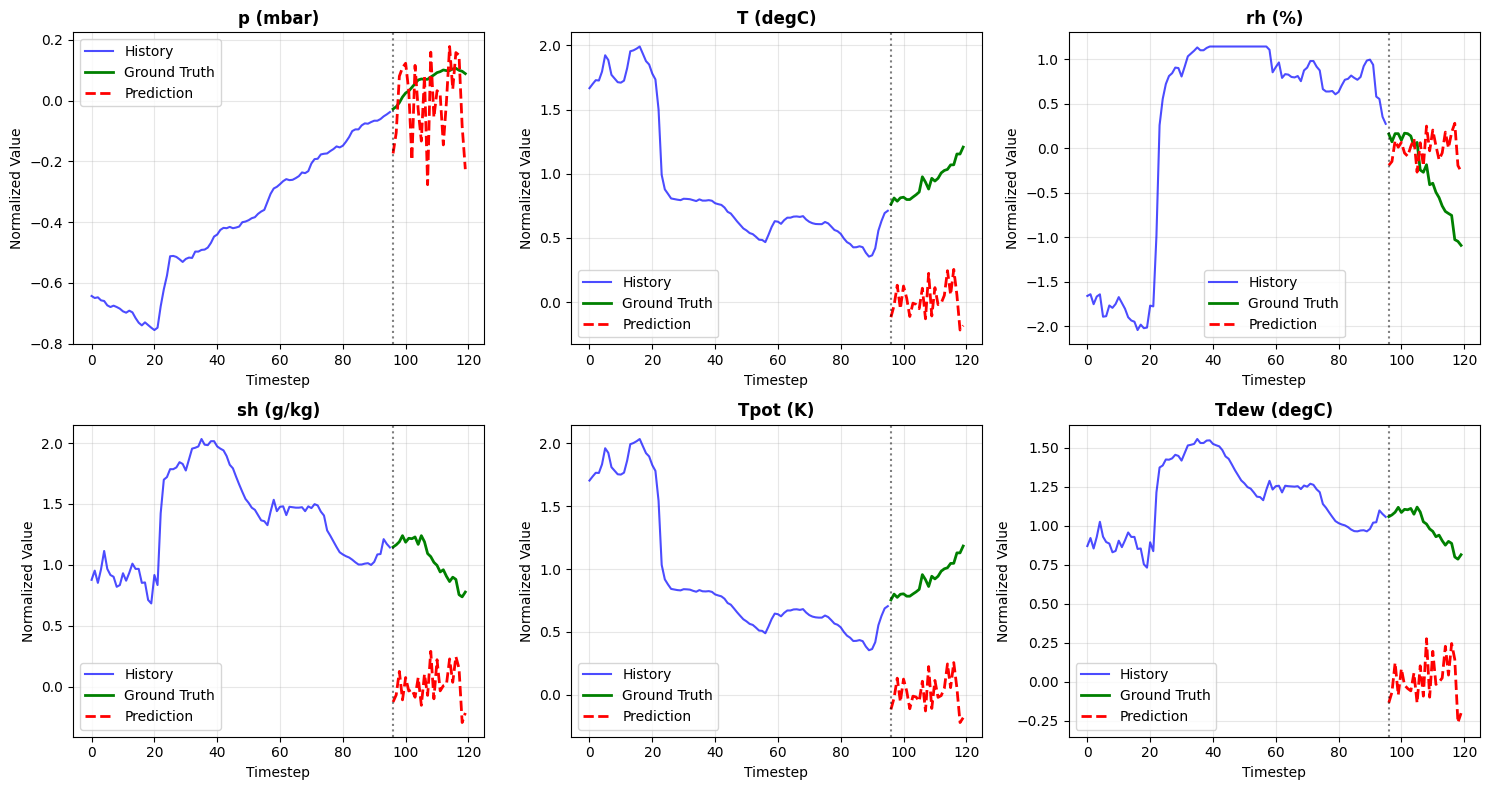

In [8]:
# Test forward pass with one batch
model.eval()
with torch.no_grad():
    x_test, y_test = next(iter(test_loader))
    x_test = x_test.to(device)
    y_test = y_test.to(device)

    print(f"Input shape: {x_test.shape}")

    # Forward pass
    predictions = model(x_test)

    print(f"Output shape: {predictions.shape}")

    # Calculate MSE
    mse = nn.MSELoss()(predictions, y_test)
    print(f"Initial MSE (untrained): {mse.item():.4f}")

    # ===== SIMPLE PANDAS VISUALIZATION =====
    # Get first example and move to CPU
    x_sample = x_test[0].cpu().numpy()
    y_sample = y_test[0].cpu().numpy()
    pred_sample = predictions[0].cpu().numpy()

    # Get column names (exclude 'Date Time')
    variate_names = df.columns[1:].tolist()

    # Create DataFrames
    df_history = pd.DataFrame(x_sample, columns=variate_names)
    df_history['type'] = 'history'
    df_history['timestep'] = range(len(df_history))

    df_truth = pd.DataFrame(y_sample, columns=variate_names)
    df_truth['type'] = 'ground_truth'
    df_truth['timestep'] = range(lookback_steps, lookback_steps + len(df_truth))

    df_pred = pd.DataFrame(pred_sample, columns=variate_names)
    df_pred['type'] = 'prediction'
    df_pred['timestep'] = range(lookback_steps, lookback_steps + len(df_pred))

    # Plot first 6 variates
    variates_to_plot = variate_names[:6]

    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()

    for i, var_name in enumerate(variates_to_plot):
        ax = axes[i]

        # Plot history
        df_history.plot(x='timestep', y=var_name, ax=ax, label='History',
                       color='blue', alpha=0.7, legend=False)

        # Plot ground truth
        df_truth.plot(x='timestep', y=var_name, ax=ax, label='Ground Truth',
                     color='green', linewidth=2, legend=False)

        # Plot predictions
        df_pred.plot(x='timestep', y=var_name, ax=ax, label='Prediction',
                    color='red', linestyle='--', linewidth=2, legend=False)

        ax.axvline(x=lookback_steps, color='black', linestyle=':', alpha=0.5)
        ax.set_title(var_name, fontweight='bold')
        ax.set_xlabel('Timestep')
        ax.set_ylabel('Normalized Value')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

## 5. Training Loop

In [9]:
from tqdm import tqdm
import torch.optim.lr_scheduler
import os
from datetime import datetime

# Training setup
criterion = nn.MSELoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
num_epochs = 4

# Training history
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0

    # Progress bar for training batches
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
    for x_batch, y_batch in pbar:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        # Forward pass
        optimizer.zero_grad()
        predictions = model(x_batch)
        loss = criterion(predictions, y_batch)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Update progress bar
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Evaluation
    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        pbar_test = tqdm(test_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Test]')
        for x_batch, y_batch in pbar_test:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            predictions = model(x_batch)
            loss = criterion(predictions, y_batch)
            test_loss += loss.item()

            pbar_test.set_postfix({'loss': f'{loss.item():.4f}'})

    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    # Scheduler step
    scheduler.step(test_loss)

    # Get current learning rate from optimizer
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, LR: {current_lr}\n")

# Create experiments directory if it doesn't exist
os.makedirs('./experiments', exist_ok=True)

# Generate timestamp for unique filename
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Save the model
model_path = f'./experiments/model_{timestamp}.pth'
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'test_losses': test_losses,
    'final_train_loss': train_losses[-1],
    'final_test_loss': test_losses[-1],
}, model_path)

print(f"\nModel saved to: {model_path}")
print(f"Final Train Loss: {train_losses[-1]:.4f}")
print(f"Final Test Loss: {test_losses[-1]:.4f}")

Epoch 1/4 [Test]: 100%|██████████| 116/116 [00:24<00:00,  4.69it/s, loss=0.0644]


Epoch [1/4] - Train Loss: 0.1633, Test Loss: 0.1414, LR: 0.001



Epoch 2/4 [Test]: 100%|██████████| 116/116 [00:24<00:00,  4.73it/s, loss=0.0571]


Epoch [2/4] - Train Loss: 0.1285, Test Loss: 0.1314, LR: 0.001



Epoch 3/4 [Test]: 100%|██████████| 116/116 [00:24<00:00,  4.72it/s, loss=0.0539]


Epoch [3/4] - Train Loss: 0.1220, Test Loss: 0.1269, LR: 0.001



Epoch 4/4 [Test]: 100%|██████████| 116/116 [00:24<00:00,  4.76it/s, loss=0.0540]

Epoch [4/4] - Train Loss: 0.1182, Test Loss: 0.1244, LR: 0.001


Model saved to: ./experiments/model_20251203_003625.pth
Final Train Loss: 0.1182
Final Test Loss: 0.1244


## 6. Training Progress

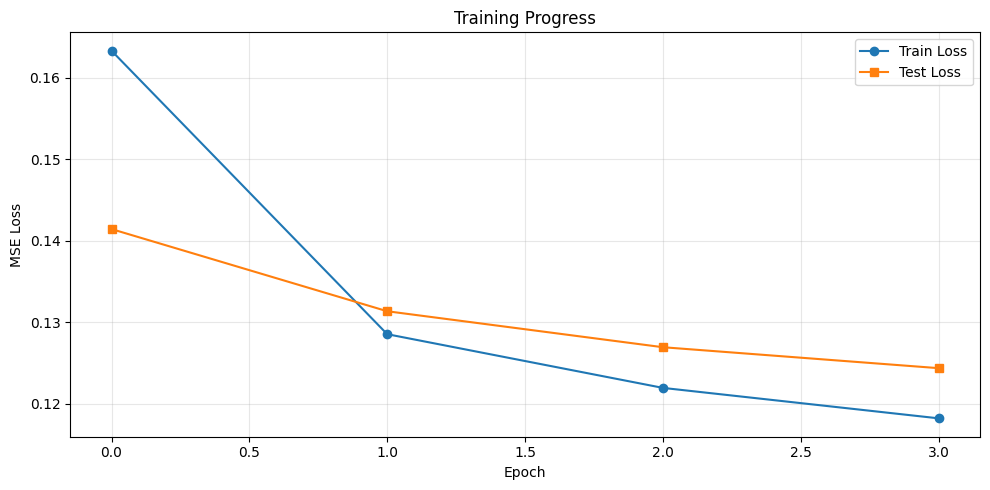

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(test_losses, label='Test Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Visualize Predictions

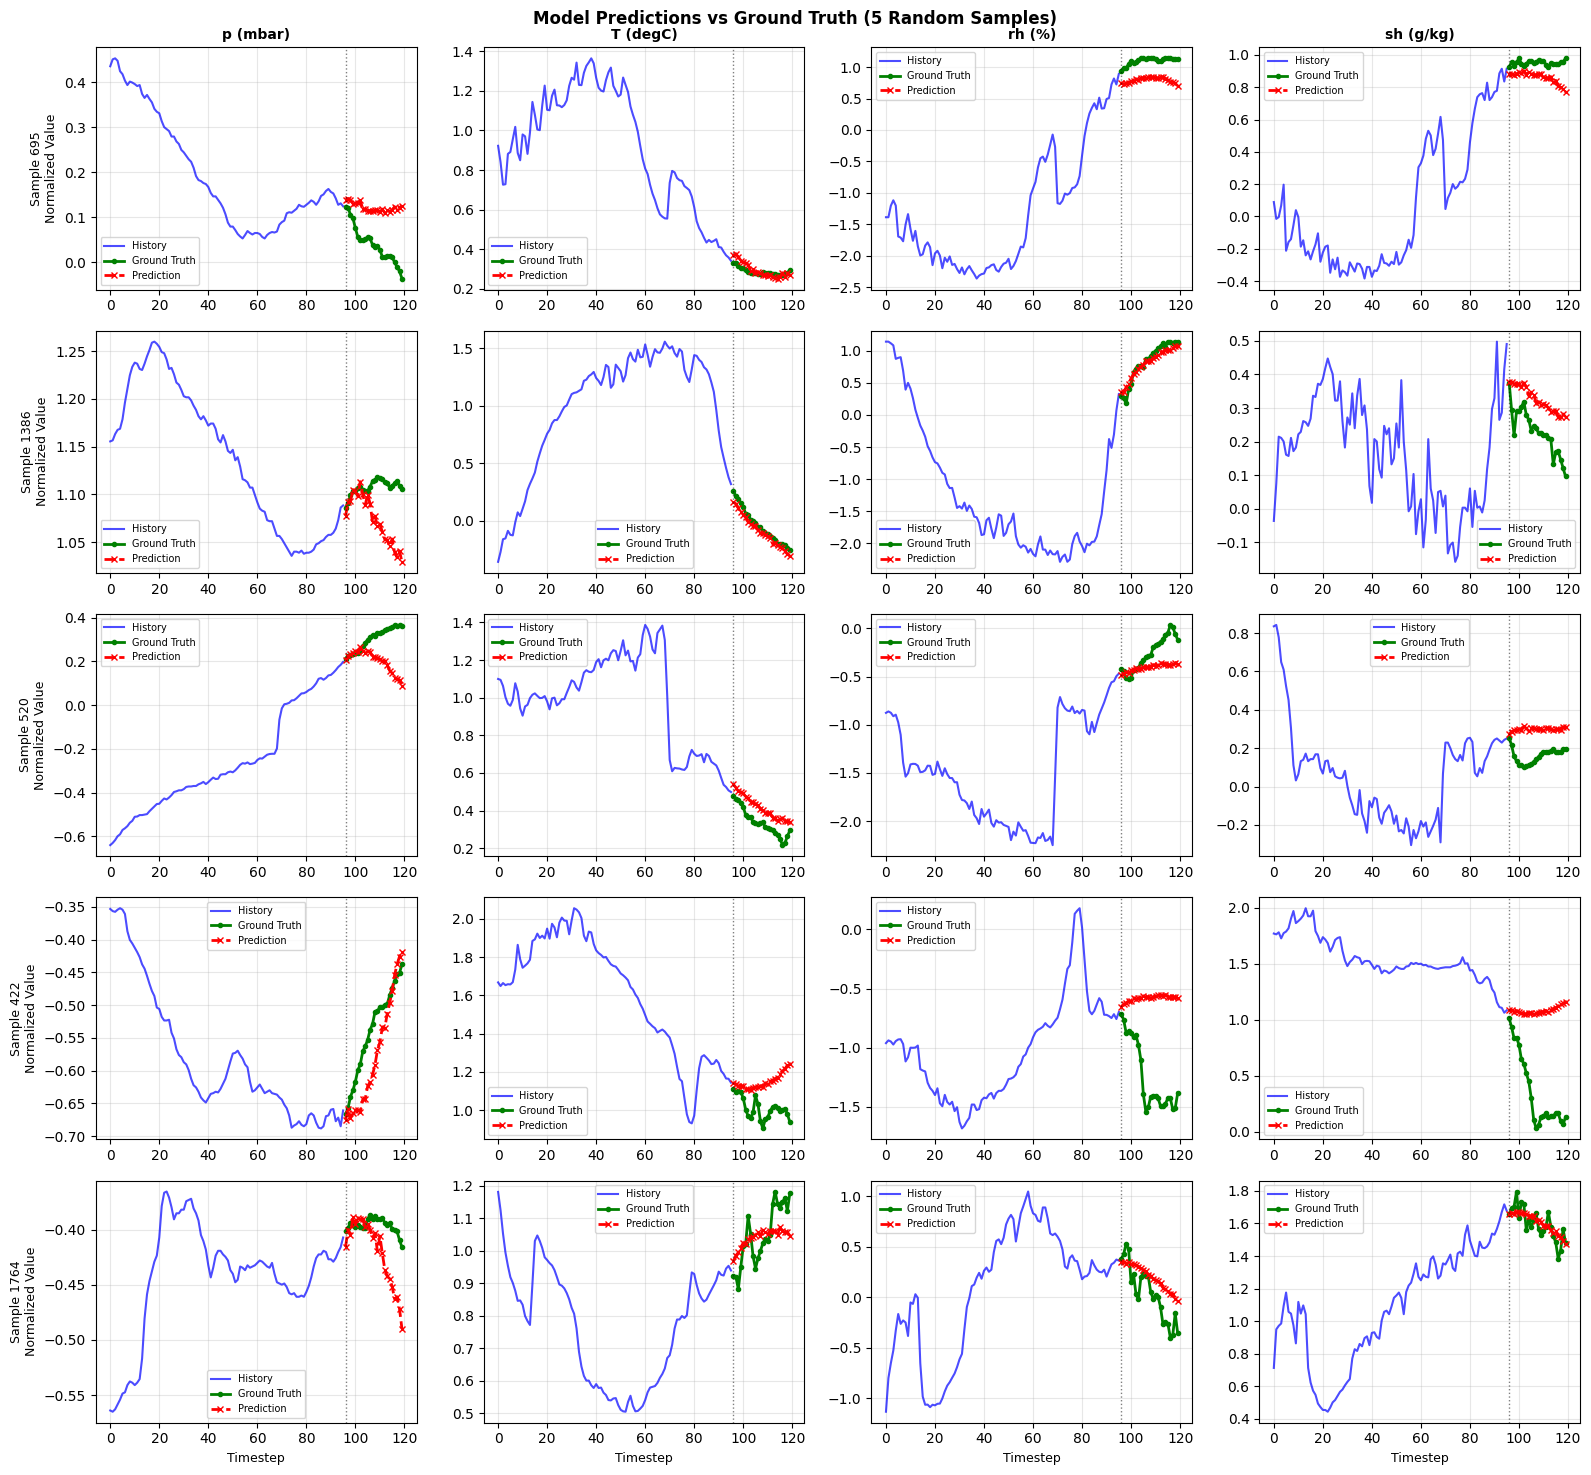

In [11]:
NUM_SAMPLES_TO_CHECK = 5

model.eval()
with torch.no_grad():
    # Get a test batch
    x_test, y_test = next(iter(test_loader))
    x_test = x_test.to(device)
    y_test = y_test.to(device)
    predictions = model(x_test)

    # Randomly sample from the batch
    batch_size = x_test.shape[0]
    num_samples = min(NUM_SAMPLES_TO_CHECK, batch_size)

    # Randomly select samples
    sample_indices = np.random.choice(batch_size, num_samples, replace=False)

    # Get column names (exclude 'Date Time')
    variate_names = df.columns[1:].tolist()

    # Create subplot grid
    rows = num_samples
    cols = min(4, len(variate_names))  # Show up to 4 variates per sample

    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))
    if rows == 1:
        axes = axes.reshape(1, -1)
    if cols == 1:
        axes = axes.reshape(-1, 1)

    for i, sample_idx in enumerate(sample_indices):
        # Get data for this sample
        x_sample = x_test[sample_idx].cpu().numpy()
        y_sample = y_test[sample_idx].cpu().numpy()
        pred_sample = predictions[sample_idx].cpu().numpy()

        # Plot each variate
        for j, var_name in enumerate(variate_names[:cols]):
            ax = axes[i, j]

            # Plot history (lookback)
            history_timesteps = range(len(x_sample))
            ax.plot(history_timesteps, x_sample[:, j],
                   label='History', color='blue', alpha=0.7, linewidth=1.5)

            # Plot ground truth (forecast)
            forecast_timesteps = range(len(x_sample), len(x_sample) + len(y_sample))
            ax.plot(forecast_timesteps, y_sample[:, j],
                   label='Ground Truth', color='green', linewidth=2, marker='o', markersize=3)

            # Plot predictions (forecast)
            ax.plot(forecast_timesteps, pred_sample[:, j],
                   label='Prediction', color='red', linestyle='--', linewidth=2, marker='x', markersize=4)

            # Add vertical line separating history and forecast
            ax.axvline(x=len(x_sample), color='black', linestyle=':', alpha=0.5, linewidth=1)

            # Set titles and labels
            if i == 0:
                ax.set_title(f'{var_name}', fontweight='bold', fontsize=10)
            if j == 0:
                ax.set_ylabel(f'Sample {sample_idx}\nNormalized Value', fontsize=9)
            if i == rows - 1:
                ax.set_xlabel('Timestep', fontsize=9)

            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=7)

    plt.suptitle(f'Model Predictions vs Ground Truth ({num_samples} Random Samples)', fontweight='bold', fontsize=12)
    plt.tight_layout()
    plt.show()